In [39]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

In [3]:
ddb_roundabout = gpd.read_file('./data/ddb_roundabout.geojson')

In [7]:
ddb_roundabout.head()

,timestamp,xacc,yacc,speed,maxspeed,lanecount,classification,index_right,distances,geometry
0,2020-12-17 01:46:30+00:00,-0.889,0.002,7,32,1,Braking,402.0,78.508285,POINT (16595825.835 -4208110.694)
1,2020-07-05 23:53:50+00:00,-0.864,0.000,3,48,1,Braking,70.0,27.548220,POINT (16597539.710 -4206559.210)
2,2020-07-05 23:53:50+00:00,-0.864,0.000,3,48,1,Braking,903.0,27.548220,POINT (16597539.710 -4206559.210)
3,2020-04-25 19:27:59+00:00,-0.346,0.714,27,45,1,Steering,70.0,4.927812,POINT (16597536.370 -4206536.837)
4,2020-04-25 19:27:59+00:00,-0.346,0.714,27,45,1,Steering,903.0,4.927812,POINT (16597536.370 -4206536.837)


In [5]:
crash_roundabout = gpd.read_file('./data/crash_roundabout.geojson')

In [8]:
crash_roundabout.head()

,CRASH_DATE,CRASH_TIME,SUBURB_LOCATION,LONGITUDE,LATITUDE,INTERSECTION,MIDBLOCK,CRASH_DIRECTION,CRASH_SEVERITY,LIGHTING_CONDITION,ROAD_CONDITION,WEATHER_CONDITION,Location,index_right,distances,geometry
0,14/03/2014,14:45:00,WANNIASSA,149.105038,-35.394988,YES,NO,North bound,Property Damage Only,Daylight,Good dry surface,Fine,"(-35.394987516718835, 149.1050382804053)",124.0,54.232167,POINT (16598296.938 -4217688.770)
1,25/09/2013,09:15:00,PARKES,149.140739,-35.290364,YES,NO,South bound,Injury,Daylight,Good dry surface,Fine,"(-35.2903638694626, 149.14073893625283)",598.0,18.107638,POINT (16602271.111 -4203410.781)
2,21/10/2014,12:50:00,WESTON,149.052234,-35.342376,YES,NO,South / West bound,Injury,Daylight,Good dry surface,Fine,"(-35.342376051736125, 149.05223439721874)",109.0,52.375484,POINT (16592418.835 -4210506.572)
3,18/12/2014,15:00:00,CURTIN,149.085469,-35.336601,YES,NO,North bound,Property Damage Only,Daylight,Good dry surface,Fine,"(-35.33660063969841, 149.08546898336647)",302.0,37.911366,POINT (16596118.494 -4209718.433)
4,04/08/2015,07:10:00,CURTIN,149.085534,-35.336096,YES,NO,North / East bound,Injury,Daylight,Good dry surface,Fine,"(-35.336095898518856, 149.0855345007159)",302.0,1.119271,POINT (16596125.785 -4209649.556)


In [35]:
def check_graph(nxgraph):
    # Check if the graph has any nodes.
    print("Graph nodes:")
    if nxgraph.number_of_nodes() > 0:
        print("The graph has nodes.")
    else:
        print("The graph does not have any nodes.")
    # Check if the graph has any edges.
    print("\nGraph edges:")
    if nxgraph.number_of_edges() > 0:
        print("The graph has edges.")
    else:
        print("The graph does not have any edges.")
    # Check if the graph is connected.
    print("\nGraph connection:")
    if nx.is_connected(nxgraph):
        print("The graph is connected.")
    else:
        print("The graph is disconnected.")
        

Graph Construction DDB Option 1

In [9]:
#Create empty graph
G = nx.Graph()

In [10]:
# Calculate the minimum and maximum x-acceleration and y-acceleration values
max_x, min_x, max_y, min_y = -1, float('inf'), -1, float('inf')
print(f"Minimum x-acceleration: {min_x}")
print(f"Maximum x-acceleration: {max_x}")
print(f"Minimum y-acceleration: {min_y}")
print(f"Maximum y-acceleration: {max_y}")

Minimum x-acceleration: inf
Maximum x-acceleration: -1
Minimum y-acceleration: inf
Maximum y-acceleration: -1


In [11]:
#iterate ddb roundabout dataset for nodes and metric
for index, row in ddb_roundabout.iterrows():
    # Calculate the minimum and maximum x-acceleration and y-acceleration values
    max_x = max(max_x, row['xacc'])
    min_x = min(min_x, row['xacc'])
    max_y = max(max_y, row['yacc'])
    min_y = min(min_y, row['yacc'])

    #add nodes to graph
    location = row['geometry']
    x_acc = row['xacc']
    y_acc = row['yacc']

    G.add_node(location) 
    G.nodes[location]['xacc'] = x_acc
    G.nodes[location]['yacc'] = y_acc

In [12]:
G

In [13]:
print(f"Minimum x-acceleration: {min_x}")
print(f"Maximum x-acceleration: {max_x}")
print(f"Minimum y-acceleration: {min_y}")
print(f"Maximum y-acceleration: {max_y}")

Minimum x-acceleration: -1.962
Maximum x-acceleration: 1.116
Minimum y-acceleration: -1.096
Maximum y-acceleration: 0.957


In [14]:
#Similarity Metric
def calculate_similarity(node1, node2, max_x, min_x, max_y, min_y):
    # Extract feature values from nodes (locations)
    x1 = G.nodes[node1]['xacc']
    y1 = G.nodes[node1]['yacc']
    
    x2 = G.nodes[node2]['xacc']
    y2 = G.nodes[node2]['yacc']
    
    # Calculate Euclidean distance between feature vectors
    euclidean_distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    # Normalize the distance to a similarity score (higher values indicate more similarity)
    max_possible_distance = np.sqrt((max_x - min_x)**2 + (max_y - min_y)**2)  # Adjust as needed
    similarity_score = 1 - (euclidean_distance / max_possible_distance)
    
    return similarity_score

In [17]:
#add edges to nodes based on similarity metric
#iterate through nodes to create edges based on similarity
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            # Calculate similarity
            similarity_score = calculate_similarity(node1, node2, max_x, min_x, max_y, min_y)
            
            #threshold for considering edges
            threshold = 0.7

            # Add edge based on similarity
            if similarity_score > threshold:
                G.add_edge(node1, node2, similarity=similarity_score)

In [36]:
check_graph(G)

Graph nodes:
The graph has nodes.

Graph edges:
The graph has edges.

Graph connection:
The graph is connected.


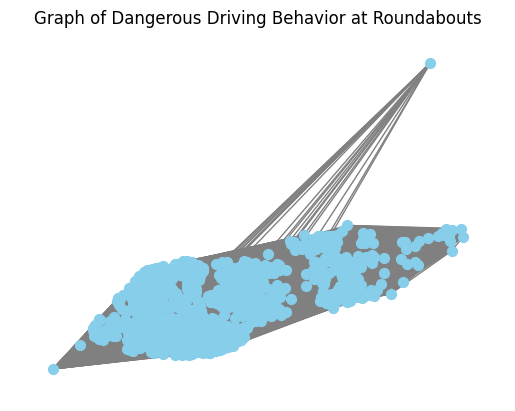

In [20]:
#Visualize Graph
# Create a layout for the nodes
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=50)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Label nodes with their location (you can customize labels as needed)
#labels = {node: node for node in G.nodes()}
#nx.draw_networkx_labels(G, pos, labels, font_size=8)

# Set plot options
plt.title("Graph of Dangerous Driving Behavior at Roundabouts")
plt.axis('off')

# Show the plot
plt.show()

Graph Construction DDB Option 1 B

In [41]:
#new graph for option 1B
GB = nx.Graph()

In [42]:
#iterate ddb roundabout dataset for nodes and metric
for index, row in ddb_roundabout.iterrows():
    # Calculate the minimum and maximum x-acceleration and y-acceleration values
    max_x = max(max_x, row['xacc'])
    min_x = min(min_x, row['xacc'])
    max_y = max(max_y, row['yacc'])
    min_y = min(min_y, row['yacc'])

    #add nodes to graph
    location = row['geometry']
    x_acc = row['xacc']
    y_acc = row['yacc']

    GB.add_node(location) 
    GB.nodes[location]['xacc'] = x_acc
    GB.nodes[location]['yacc'] = y_acc

In [52]:
#Jaccard coefficient between all nodes in a graph for similarity
GB_node_similarity = nx.jaccard_coefficient(GB)

In [ ]:
#Group similar nodes
clustered_nodes = nx.

In [ ]:
#New nodes based on grouped nodes
group_nodes = []

Graph Construction DDB Option 2

In [21]:
#Create empty graph
G2 = nx.Graph()

In [22]:
# Calculate the minimum and maximum x-acceleration and y-acceleration values
max_x, min_x, max_y, min_y = -1, float('inf'), -1, float('inf')
print(f"Minimum x-acceleration: {min_x}")
print(f"Maximum x-acceleration: {max_x}")
print(f"Minimum y-acceleration: {min_y}")
print(f"Maximum y-acceleration: {max_y}")

Minimum x-acceleration: inf
Maximum x-acceleration: -1
Minimum y-acceleration: inf
Maximum y-acceleration: -1


In [23]:
#iterate ddb roundabout dataset for nodes and metric
for index, row in ddb_roundabout.iterrows():
    # Calculate the minimum and maximum x-acceleration and y-acceleration values
    max_x = max(max_x, row['xacc'])
    min_x = min(min_x, row['xacc'])
    max_y = max(max_y, row['yacc'])
    min_y = min(min_y, row['yacc'])

    #add nodes to graph
    G2.add_node(row['geometry'])

In [38]:
#Calculates the distance between two nodes, given their coordinates.
#Harvesine formula
def calculate_distance(node1, node2, max_x, min_x, max_y, min_y):
  # Convert decimal degrees to radians 
  lon1, lat1, lon2, lat2 = map(radians, [node1.x, node1.y, node2.x, node2.y])

  # Calculate the difference in latitude and longitude between the two nodes.
  dlon = lon2 - lon1 
  dlat = lat2 - lat1

  # Calculate the distance between the two nodes using the Haversine formula.
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a))
  distance = c * 6371 # distance in metres

  max_dist = np.sqrt((max_x - min_x)**2 + (max_y - min_y)**2)  # Adjust as needed

  similarity = 1 - (distance / max_dist)

  return similarity

In [25]:
#edges
threshold = 0.7
i, j = 0, 0
for node_i in G2.nodes:
    for node_j in G2.nodes:
        if node_i != node_j:
            # Calculate the distance between node i and node j.
            similarity = calculate_distance(node_i, node_j, max_x, min_x, max_y, min_y)
            if similarity < threshold:
                G2.add_edge(node_i, node_j)
            j += 1
    j = 0
    i += 1

In [26]:
G2

In [37]:
check_graph(G2)

Graph nodes:
The graph has nodes.

Graph edges:
The graph has edges.

Graph connection:
The graph is connected.


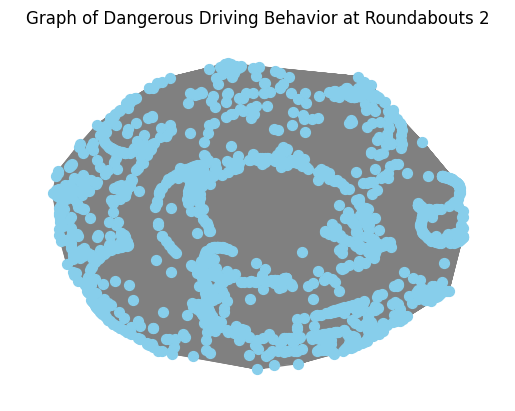

In [32]:
# Set the node positions using a force-directed layout.
pos = nx.spring_layout(G2)

# Draw the graph.
nx.draw_networkx_nodes(G2, pos=pos, node_color='skyblue', node_size=50)

# Draw edges
nx.draw_networkx_edges(G2, pos, edge_color='gray')

# Set plot options
plt.title("Graph of Dangerous Driving Behavior at Roundabouts 2")
plt.axis('off')

# Show the plot.
plt.show()

Graph Construction DDB Option 2 B

In [ ]:
#new graph